# Credit Card Approval Machine

Commercial bank recieves lots of credit card application every day. If each application is done by hand by hand, there are several cons:
#### **1. Human check may have risk for missing check or making mistake.**
#### **2. It is not efficient for the staff to check lots of data**

As a result, creating a program that it can be a assisstant for operator to check each application and make a right decision. Here is the pros:
#### **1. The program can have high accuracy and precision rate to classify qualified & dis-qualified**
#### **2. It can enhance the staff's working efficiency.**

# Start creating a machine

## Here are the steps:
1. Check datatype, missing values
2. Convert the **missing values as mean or mode**
3. Make the catrgorical variables as **dummies**
4. Do the **Standardization** or **Normalization** to make sure there are no data bias impact.
5. Do the **GridSearchCV** or **RandomizedSearchCV** to find the **best hyper-parameters**
6. Do the **Cross-validation** to find the best performace of machine learning model.
7. Draw the confusion matrix and ROC, AUC.
8. Summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn import svm
from collections import defaultdict

In [2]:
# Import pandas
import pandas as pd

# Load the dataset and need to be carefule that first row is not the column name.
column_name = [f'A{i}' for i in range(1,17)]
data = pd.read_csv('crx.data', header = None, names = column_name) 
print(data)
print(data.head())
print(data.info())

# data.loc[data['A16'] =='+', 'A16'] = 1
# data.loc[data['A16']== '-', 'A16'] = 0

data['A16'] = data['A16'].map({'+': 1, '-': 0})

# Follwoing the dataset description, column 15th is the target variale.
y = data.pop('A16')


print(y.value_counts())
print(y.unique)

    A1     A2      A3 A4 A5  A6  A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0    b  30.83   0.000  u  g   w   v  1.25  t   t    1   f   g  00202    0   +
1    a  58.67   4.460  u  g   q   h  3.04  t   t    6   f   g  00043  560   +
2    a  24.50   0.500  u  g   q   h  1.50  t   f    0   f   g  00280  824   +
3    b  27.83   1.540  u  g   w   v  3.75  t   t    5   t   g  00100    3   +
4    b  20.17   5.625  u  g   w   v  1.71  t   f    0   f   s  00120    0   +
..  ..    ...     ... .. ..  ..  ..   ... ..  ..  ...  ..  ..    ...  ...  ..
685  b  21.08  10.085  y  p   e   h  1.25  f   f    0   f   g  00260    0   -
686  a  22.67   0.750  u  g   c   v  2.00  f   t    2   t   g  00200  394   -
687  a  25.25  13.500  y  p  ff  ff  2.00  f   t    1   t   g  00200    1   -
688  b  17.92   0.205  u  g  aa   v  0.04  f   f    0   f   g  00280  750   -
689  b  35.00   3.375  u  g   c   h  8.29  f   f    0   t   g  00000    0   -

[690 rows x 16 columns]
  A1     A2     A3 A4 A5 A6 A7    A8 A9

##  Check if there is missing values

In [3]:
# Check the qualitative data if there are missing value.
qualitative_columns = ['A1','A2', 'A4','A5','A6','A7','A9','A10','A12','A13', 'A14']  # Specify the column names containing qualitative data
data_qualitative = data[qualitative_columns]
for column in qualitative_columns:
    print(data_qualitative[column].value_counts())
    print('-'*50)

# Switch the missing value '?' be an NaN
data = data.replace('?', np.NaN)

# Switch the 'A2' column as continuos variable & drop 'A14'
data['A2'] = data['A2'].astype(float)
data.pop('A14')
print(data.info())
print('-'*100)
print(y.value_counts())

b    468
a    210
?     12
Name: A1, dtype: int64
--------------------------------------------------
?        12
22.67     9
20.42     7
18.83     6
24.50     6
         ..
48.25     1
28.33     1
18.75     1
18.50     1
36.42     1
Name: A2, Length: 350, dtype: int64
--------------------------------------------------
u    519
y    163
?      6
l      2
Name: A4, dtype: int64
--------------------------------------------------
g     519
p     163
?       6
gg      2
Name: A5, dtype: int64
--------------------------------------------------
c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25
j      10
?       9
r       3
Name: A6, dtype: int64
--------------------------------------------------
v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6
n       4
o       2
Name: A7, dtype: int64
--------------------------------------------------
t    361
f    329
Name: A9, dtype: int64
-----------------

## Split the data to X_train, X_val,  y_train, y_val

In [4]:
# Split the data to training & testing dataset
X_train, X_val, y_train, y_val = model_selection.train_test_split(data, y, test_size = 0.3, random_state = 42)
print(X_train)
print(X_val)
print(y_train)
print(y_val)

    A1     A2      A3   A4   A5   A6   A7      A8 A9 A10  A11 A12 A13   A15
178  a  18.42   9.250    u    g    q    v   1.210  t   t    4   f   g   540
265  b  17.08   0.085    y    p    c    v   0.040  f   f    0   f   g   722
352  b  22.50  11.500    y    p    m    v   1.500  f   f    0   t   g  4000
529  b  43.25  25.210    u    g    q    h   0.210  t   t    1   f   g    90
409  b  17.08   0.250    u    g    q    v   0.335  f   t    4   f   g     8
..  ..    ...     ...  ...  ...  ...  ...     ... ..  ..  ...  ..  ..   ...
71   b  34.83   4.000    u    g    d   bb  12.500  t   f    0   t   g     0
106  b  28.75   1.165    u    g    k    v   0.500  t   f    0   f   s     0
270  b  37.58   0.000  NaN  NaN  NaN  NaN   0.000  f   f    0   f   p     0
435  b  19.00   0.000    y    p   ff   ff   0.000  f   t    4   f   g     1
102  b  18.67   5.000    u    g    q    v   0.375  t   t    2   f   g    38

[483 rows x 14 columns]
      A1     A2     A3 A4 A5   A6   A7     A8 A9 A10  A11 A12 A

## Replace the NaN as mean or mode

In [5]:
# Impute the missing values with mean imputation for quantitative data
X_train.fillna(X_train.mean(), inplace = True)
X_val.fillna(X_train.mean())

# Impute the missing values with mode imputation for qualitative data
for col in X_train.columns:
    if X_train[col].dtypes == 'object':
        X_train = X_train.fillna(X_train[col].value_counts().index[0])
print(X_train.isnull().sum())



for col in X_val.columns:
    if X_val[col].dtypes == 'object':
        X_val = X_val.fillna(X_train[col].value_counts().index[0])
print(X_val.isnull().sum())

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A15    0
dtype: int64
A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A15    0
dtype: int64


/var/folders/1h/xd7jgtrn02x5wg9csn4z01j40000gn/T/ipykernel_3992/76087973.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train.fillna(X_train.mean(), inplace = True)
/var/folders/1h/xd7jgtrn02x5wg9csn4z01j40000gn/T/ipykernel_3992/76087973.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_val.fillna(X_train.mean())


## Convert the catgory variables into continuous variables

In [6]:
X_train = pd.get_dummies(X_train, drop_first = True) # Get K-1 dummy out of K categorical levels by removing first level.
X_val = pd.get_dummies(X_val, drop_first = True)
print(X_val)
print('-'*100)
print(X_val)
X_val = X_val.reindex(columns= X_train.columns, fill_value=0)

        A3     A8  A11   A15  A1_b  A2_15.75  A2_16.0  A2_16.08  A2_16.17  \
286  1.500  0.000    2   105     0         0        0         0         0   
511  4.000  0.000    0   960     0         0        0         0         0   
257  0.000  0.500    0     0     1         0        0         0         0   
336  6.500  1.000    0   228     1         0        0         0         0   
318  0.000  0.000    0     1     1         0        0         0         0   
..     ...    ...  ...   ...   ...       ...      ...       ...       ...   
601  1.750  0.000    0     1     1         0        0         0         0   
66   1.000  2.000   11   456     0         0        0         0         0   
11   1.835  4.335    0   200     1         0        0         0         0   
674  2.500  0.210    0   246     0         0        0         0         0   
559  2.290  2.290    7  2384     0         0        0         0         0   

     A2_16.25  ...  A7_h  A7_j  A7_n  A7_v  A7_z  A9_t  A10_t  A12_t  A13_p

In [7]:
# Do the Standardization or Normalization.
standardizer = preprocessing.StandardScaler()
X_train_scaled = standardizer.fit_transform(X_train)
X_val_scaled = standardizer.transform(X_val)

## Since this is binary classification problem, I choose these models:

1. Logistic Regression
2. Random forest
3. SVM
4. Bagging --> Random Forest
5. XGBoost --> Gradient Boost Classifier , this will be implemented individual

In [16]:
# K-fold
kf = model_selection.KFold(n_splits = 4, shuffle = True, random_state = 42)

model_choose = {
    'Logistic_Regression':{
    'model':linear_model.LogisticRegression(), 
    'param_grid':{'C':[round(float(x),2) for x in np.linspace(0.01,1, num = 10)]}
    },
    'Random_Forest':{
    'model':ensemble.RandomForestClassifier(), 
    'param_grid':{'max_depth': [int(x) for x in np.linspace(5,20, num = 1)],
                  'min_samples_leaf': [int(x) for x in np.linspace(10,40,num = 3)]}
    },
    'SVM':{
    'model':svm.SVC(), 
    'param_grid':{'kernel': ['linear', 'poly', 'rbf'], 
                  'C': [round(float(x), 2) for x in np.linspace(0.1,30, num = 5)]}
    },
    'Bagging':{
    'model':ensemble.BaggingClassifier(base_estimator = ensemble.RandomForestClassifier()), 
    'param_grid':{'base_estimator__max_depth':[int(x) for x in np.linspace(5, 20, num = 3)],
                  'base_estimator__min_samples_leaf': [int(x) for x in np.linspace(10, 32, num = 3)]}
    },
    'XGBoost':{
    'model': xgb.XGBClassifier(),
    'param_grid':{'n_estimators' : [int(x) for x in np.linspace(50,100,num = 10)],
                  'max_depth': [int(x) for x in np.linspace(10,45,num = 6)], 
                  'learning_rate' : [round(float(x),2) for x in np.linspace(0.01,0.2,num=10)], 
                  'colsample_bytree' : [round(float(x),2) for x in np.linspace(0.1,1,num = 10)]}}
}

for name, classifier in model_choose.items():
    prune_param = model_selection.RandomizedSearchCV(classifier['model'], param_distributions = classifier['param_grid'], cv = kf)
    prune_param.fit(X_train_scaled, y_train)
    print(f'{name}:{prune_param.best_params_}, {name}:{prune_param.best_score_}')   
#     print(' '.join([f'{name}: {prune_param.best_params_}', f'{name}: {prune_param.best_score_}']))

Logistic_Regression:{'C': 0.12}, Logistic_Regression:0.8613636363636363


/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random_Forest:{'min_samples_leaf': 10, 'max_depth': 5}, Random_Forest:0.8757575757575757
SVM:{'kernel': 'linear', 'C': 0.1}, SVM:0.8489669421487603


/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was

Bagging:{'base_estimator__min_samples_leaf': 10, 'base_estimator__max_depth': 12}, Bagging:0.8736914600550965
XGBoost:{'n_estimators': 55, 'max_depth': 17, 'learning_rate': 0.16, 'colsample_bytree': 0.7}, XGBoost:0.8654786501377411


/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[14:26:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[array([0.88429752, 0.83471074, 0.82644628, 0.9       ]), array([0.90909091, 0.8677686 , 0.80165289, 0.875     ]), array([0.89256198, 0.80165289, 0.80165289, 0.9       ]), array([0.90082645, 0.87603306, 0.83471074, 0.85833333]), array([0.884297

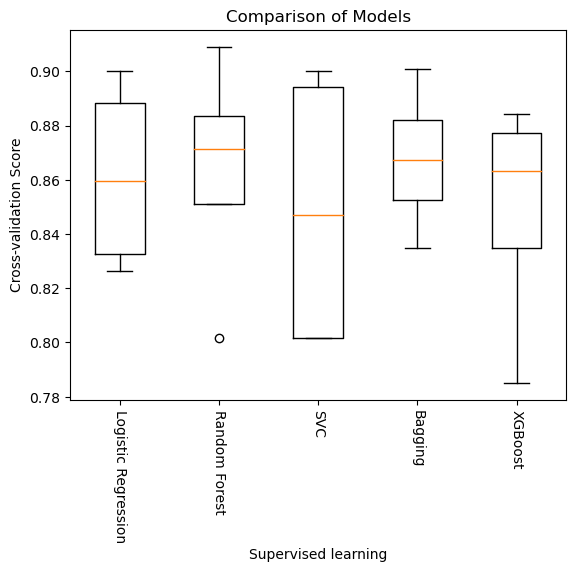

In [17]:
# Cross-Validation
models = {'Logistic Regression': linear_model.LogisticRegression(C = 0.12), 
          'Random Forest': ensemble.RandomForestClassifier(max_depth = 5,min_samples_leaf = 10),
          'SVC': svm.SVC(C = 0.1 , kernel = 'linear'),
          'Bagging': ensemble.BaggingClassifier(base_estimator=ensemble.RandomForestClassifier(max_depth = 12, min_samples_leaf = 10), n_estimators = 100),
          'XGBoost': xgb.XGBClassifier(n_estimator = 55, max_depth = 17, learning_rate = 0.16, colsample_bytree = 0.7)}
result = []
for model in models.values():
    cv_results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv = kf)
    result.append(cv_results)
print(result)
plt.boxplot(result, labels= models.keys())
plt.xlabel('Supervised learning')
plt.ylabel('Cross-validation Score')
plt.title('Comparison of Models')
plt.xticks(rotation = 270)
plt.show()

## Run the validation dataset
### - Get the output:
1. ACC for each model
2. Confusion_matrix for each model
3. classification_report for each model
==> Summarize the **Precision** & **Sensitivity (Recall)**

Logistic Regression Test Set Acc: 0.8405797101449275
[[101   9]
 [ 24  73]]
              precision    recall  f1-score   support

 Not approve       0.81      0.92      0.86       110
     Approve       0.89      0.75      0.82        97

    accuracy                           0.84       207
   macro avg       0.85      0.84      0.84       207
weighted avg       0.85      0.84      0.84       207



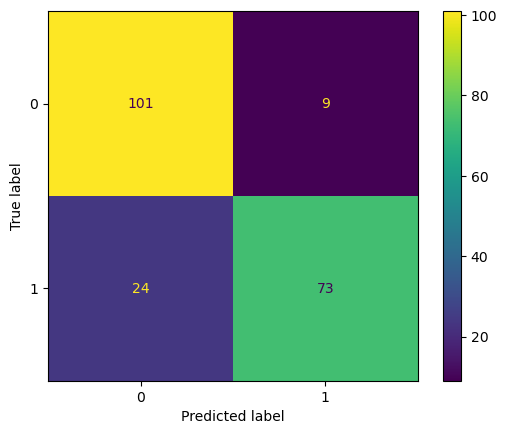

Random Forest Test Set Acc: 0.8647342995169082
[[101   9]
 [ 19  78]]
              precision    recall  f1-score   support

 Not approve       0.84      0.92      0.88       110
     Approve       0.90      0.80      0.85        97

    accuracy                           0.86       207
   macro avg       0.87      0.86      0.86       207
weighted avg       0.87      0.86      0.86       207



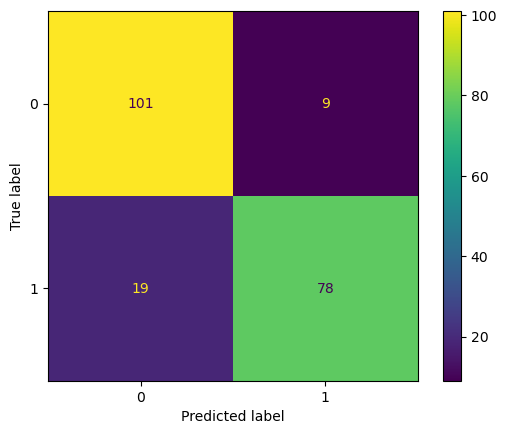

SVC Test Set Acc: 0.8309178743961353
[[85 25]
 [10 87]]
              precision    recall  f1-score   support

 Not approve       0.89      0.77      0.83       110
     Approve       0.78      0.90      0.83        97

    accuracy                           0.83       207
   macro avg       0.84      0.83      0.83       207
weighted avg       0.84      0.83      0.83       207



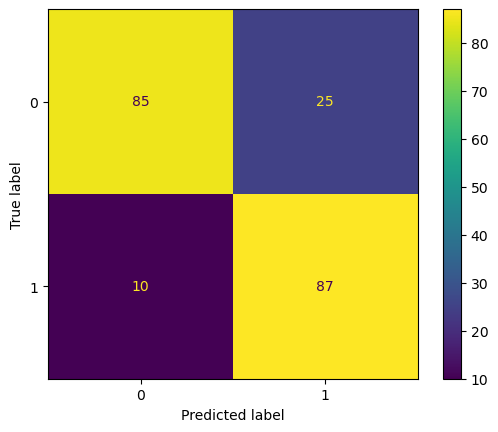

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Test Set Acc: 0.855072463768116
[[101   9]
 [ 21  76]]
              precision    recall  f1-score   support

 Not approve       0.83      0.92      0.87       110
     Approve       0.89      0.78      0.84        97

    accuracy                           0.86       207
   macro avg       0.86      0.85      0.85       207
weighted avg       0.86      0.86      0.85       207



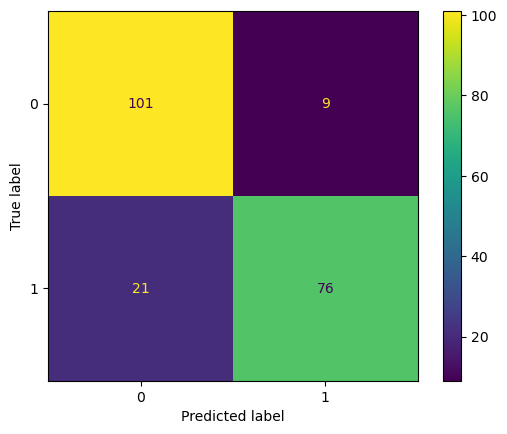

[16:55:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

XGBoost Test Set Acc: 0.8405797101449275
[[91 19]
 [14 83]]
              precision    recall  f1-score   support

 Not approve       0.87      0.83      0.85       110
     Approve       0.81      0.86      0.83        97

    accuracy                           0.84       207
   macro avg       0.84      0.84      0.84       207
weighted avg       0.84      0.84      0.84       207



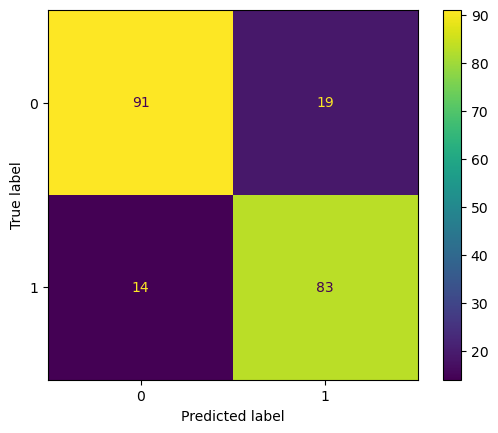

In [44]:
for name, model in models.items():
    classifier = model.fit(X_train_scaled, y_train)
    # Print val dataset ACC/ Check the mean accuracy 
    val_acc = classifier.score(X_val_scaled, y_val)
    print("{} Test Set Acc: {}".format(name, val_acc))
    # Print the confusion matrix
    y_val_pred = classifier.predict(X_val_scaled)
    matrix = metrics.confusion_matrix(y_val, y_val_pred)
    print(matrix)
    # Print the classification_report
    print(metrics.classification_report(y_val, y_val_pred, target_names = ['Not approve','Approve'])) # confusion_matrix(y_true, y_pred)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = classifier.classes_)
#     disp.plot()
#     plt.show() 
    print('='*100)

### Plot the figure to see the confusion matrix.

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[17:38:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



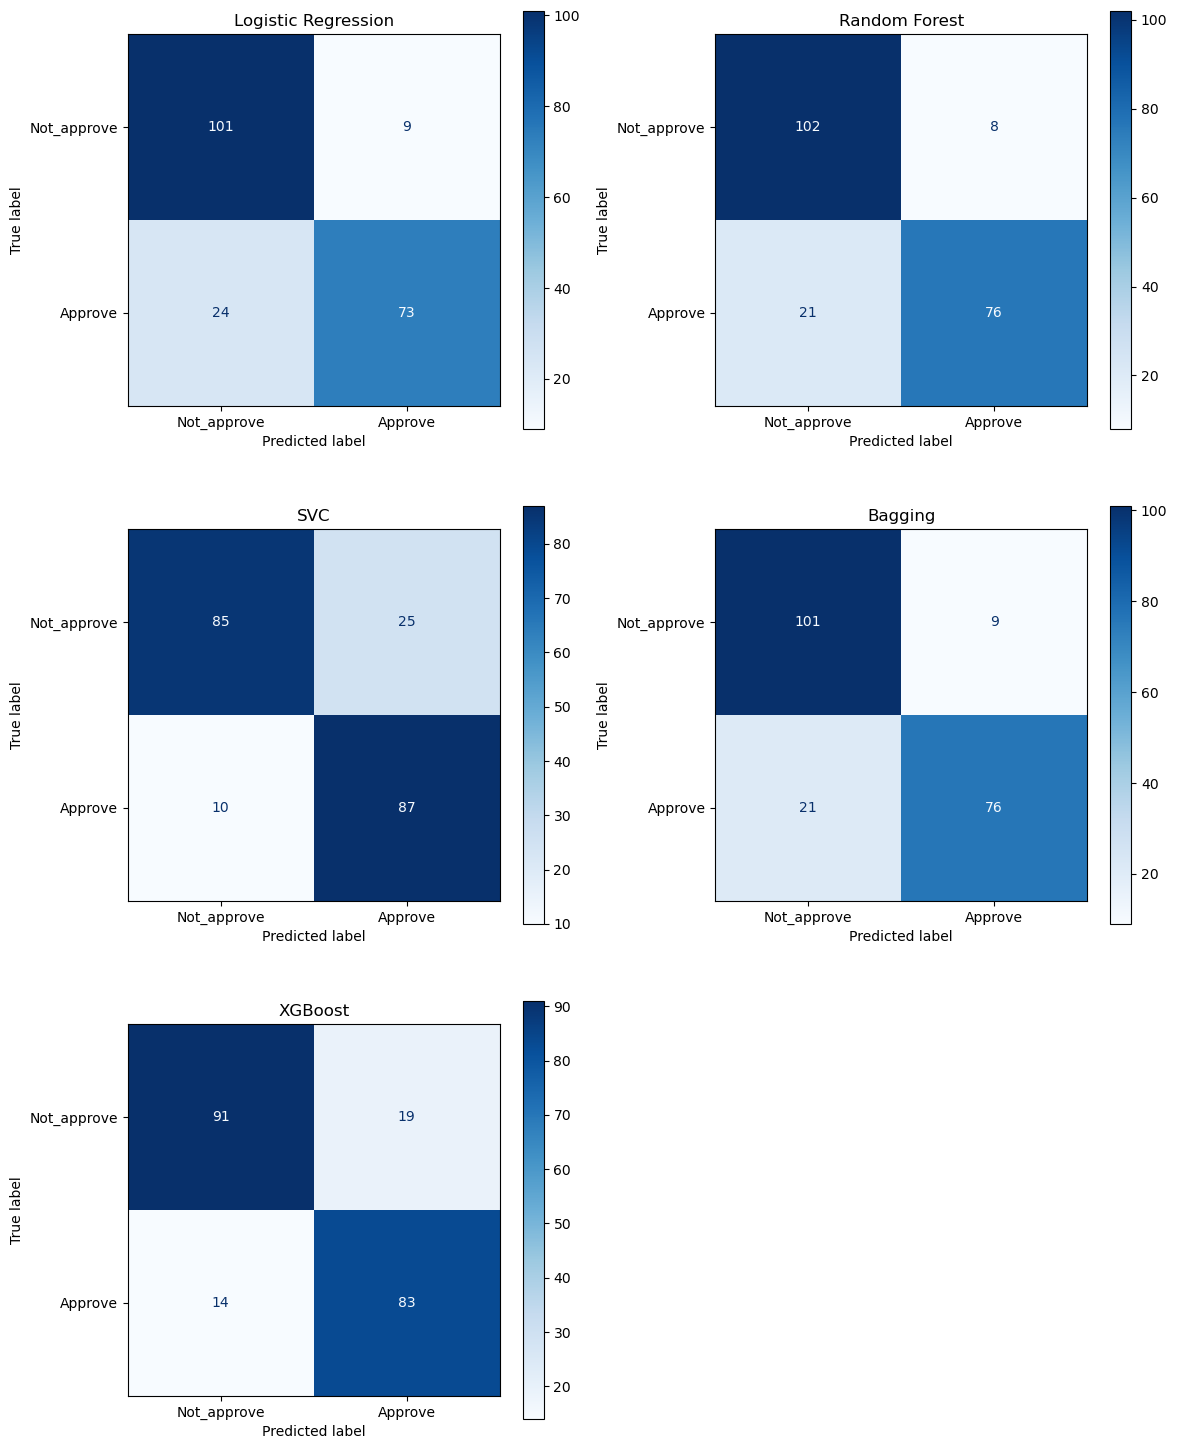

In [61]:
# Plot the confusion matrix for all models.
fig = plt.figure(figsize=(12, 15))

for i, (name, model) in enumerate(models.items()):
    if i < 5:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        matrix = metrics.confusion_matrix(y_val, y_val_pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Not_approve', 'Approve'])
        ax = plt.subplot(3, 2, i + 1)   # NOt using plt.subplots() since we only have 5 picture to plot.
        plt.title(name)
        disp.plot(ax=ax, cmap = 'Blues')

plt.tight_layout()
plt.show()


### Plot the ROC curve

/Users/yuchenwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[18:19:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



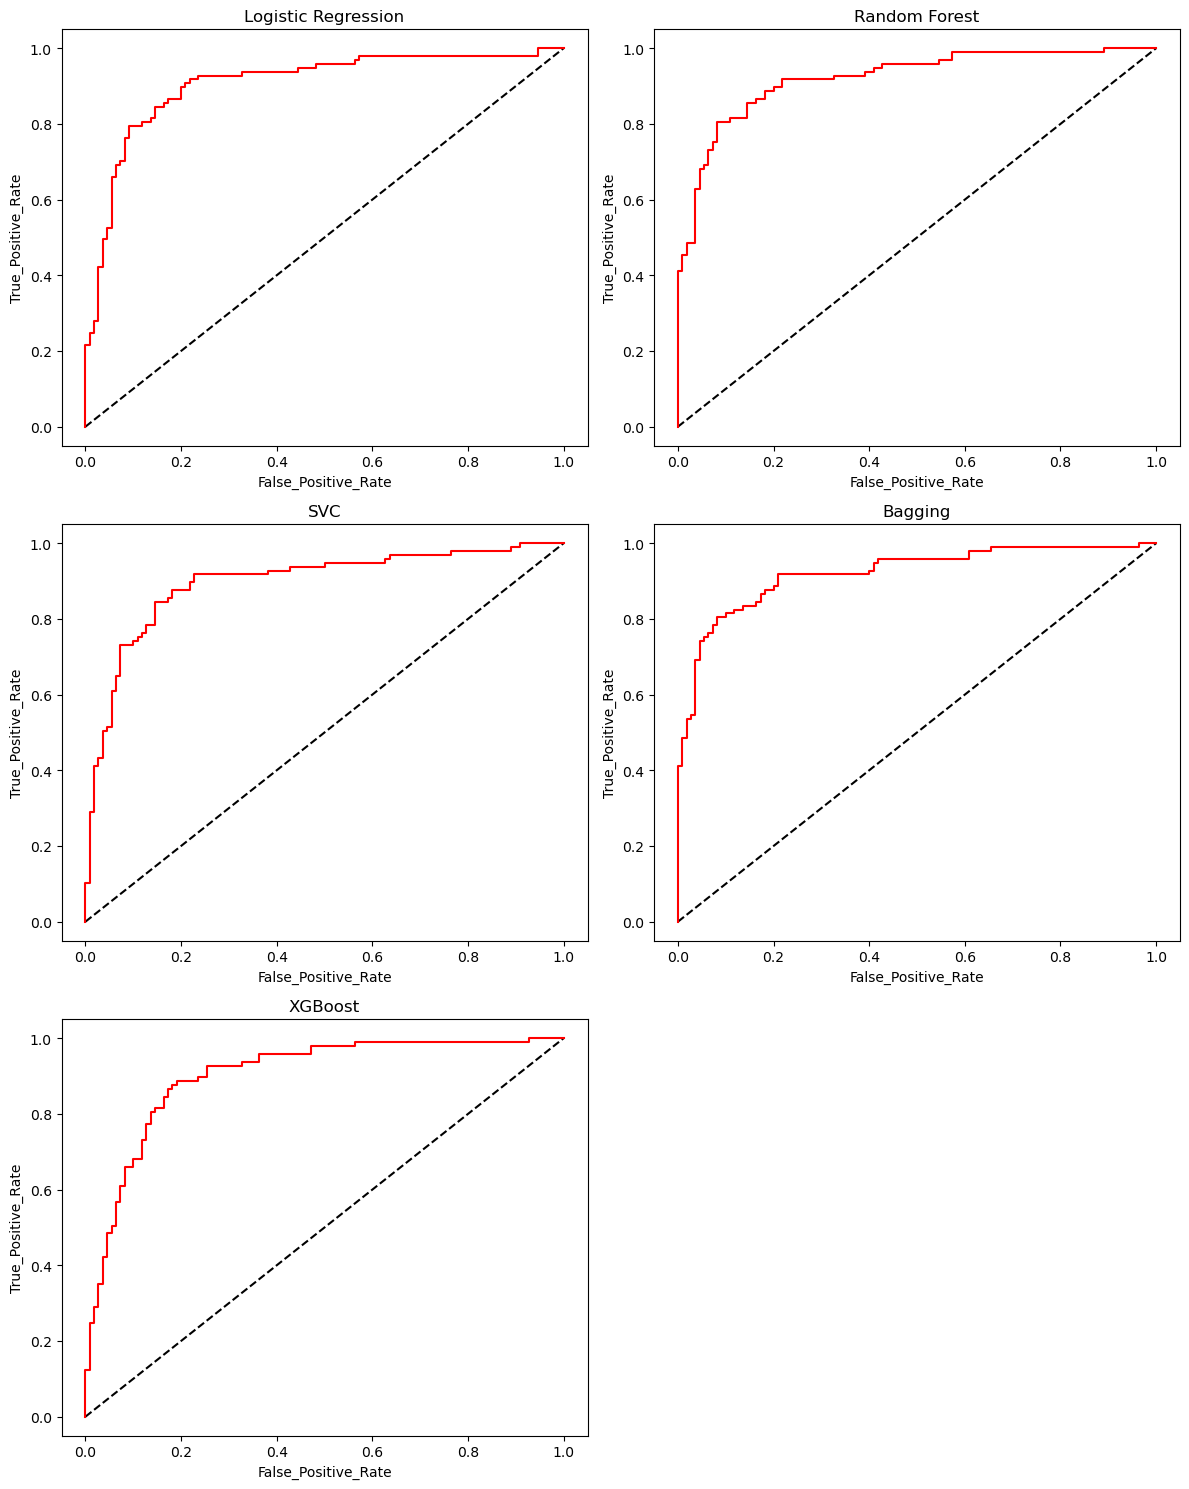

In [71]:
# Plot the ROC curve in the subplots
fig = plt.figure(figsize=(12,15))

for i, (name, model) in enumerate(models.items()):
    if i <5:
        if isinstance(model, svm.SVC):
            model.probability = True  # Set probability=True for SVM classifier
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        y_val_pred_prob = model.predict_proba(X_val_scaled)[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_val, y_val_pred_prob)
        ax = plt.subplot(3,2,i+1)
        plt.plot([0,1],[0,1], 'k--')
        plt.plot(fpr,tpr,label = name, color = 'red')
        plt.xlabel('False_Positive_Rate')
        plt.ylabel('True_Positive_Rate')
        plt.title(name)
plt.tight_layout()
plt.show()
        